In [33]:
import qcodes as qc
from qcodes.instrument_drivers.Keysight.KeysightAgilent_33XXX import WaveformGenerator_33XXX

import numpy as np
from matplotlib import pyplot as plt

In [2]:
awg = WaveformGenerator_33XXX('awg', 'TCPIP0::192.168.1.13::inst0::INSTR')

Connected to: Agilent Technologies 33512B (serial:MY52400835, firmware:3.03-1.19-2.00-52-00) in 0.12s


# Create, upload and setup arbitrary waveform

In [174]:
def def_Scurve_arb(amplitude, velocity, acceleration, Nsamples, Nbits=16):
    assert amplitude>velocity**2/acceleration, "Requires amplitude>velocity**2/acceleration"
        
    dt_accel = velocity/acceleration
    dt_cruise = amplitude/velocity - velocity/acceleration
    dy_accel = velocity**2/(2*acceleration)
    dy_cruise = amplitude - velocity**2/acceleration
    
    def y_accel(t, a, t0=0, v0=0, y0=0):
        return y0 + v0*(t-t0) + a/2 * (t-t0)**2
    
    def y_cruise(t, v, t0=0, y0=0):
        return y0 + v*(t-t0)
    
    t = np.linspace(0, 4*dt_accel + 2*dt_cruise, Nsamples)
    curve = np.piecewise(t,
                         [(t >= 0) & (t <= dt_accel),
                          (t > dt_accel) & (t <= dt_accel + dt_cruise),
                          (t > dt_accel + dt_cruise) & (t <= 3*dt_accel + dt_cruise),
                          (t > 3*dt_accel + dt_cruise) & (t <= 3*dt_accel + 2*dt_cruise),
                          (t > 3*dt_accel + 2*dt_cruise) & (t <= 4*dt_accel + 2*dt_cruise)
                         ],
                         [lambda x: y_accel(x, acceleration),
                          lambda x: y_cruise(x, velocity, dt_accel, dy_accel),
                          lambda x: y_accel(x, -acceleration, dt_accel + dt_cruise, velocity, dy_accel + dy_cruise),
                          lambda x: y_cruise(x, -velocity, 3*dt_accel + dt_cruise, dy_accel + dy_cruise),
                          lambda x: y_accel(x, acceleration, 3*dt_accel + 2*dt_cruise, -velocity, dy_accel)
                         ])
    
    arb = ((curve - amplitude/2)/(amplitude/2)*(2**Nbits/2-1)).astype(int)
    
    return (arb,
            {'amplitude': amplitude, 'offset': amplitude/2, 'period': t.max(), 'sampling_rate': Nsamples/t.max()},
            {'dt_cruise': dt_cruise, 'dy_cruise': dy_cruise})

In [175]:
vel, acc, amp = 25, 400, 5
arb, arb_param, cruise_param = def_Scurve_arb(amp, vel, acc, 10000)
arb_param, cruise_param

({'amplitude': 5,
  'offset': 2.5,
  'period': 0.525,
  'sampling_rate': 19047.619047619046},
 {'dt_cruise': 0.1375, 'dy_cruise': 3.4375})

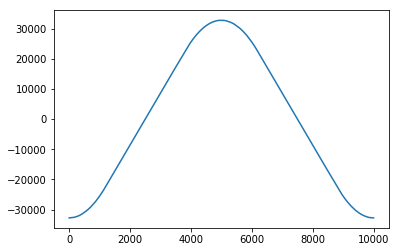

In [179]:
plt.plot(arb);

In [177]:
awg.ch2.clear_waveform_mem()
awg.ch2.make_arbitrary_waveform('myArb', arb)

awg.ch2.function_type.set('ARB')
awg.ch2.arb_waveform_fname.set('myArb')
awg.ch2.amplitude.set(arb_param['amplitude'])
awg.ch2.offset.set(arb_param['offset'])
awg.ch2.arb_waveform_srate.set(arb_param['sampling_rate'])

In [178]:
awg.flush_error_queue()

0 No error
